# ESNs

Project contents:
<ol>
  <li>Implementing a standard echo state network (ESN) model. Does not include feedback from the output and does not include leaky neurons. Considers some preliminary simulations on the k-step ahead forecasting task for sinusoidal wave data points.</li>
    
  <li>Implementing a version of the ESN model that is trained <i>online</i> using the least-mean-square algorithm. Comparisons are made with the standard ESN implementation for different k values for the k-step ahead forecasting tasks using the sinusoidal and lorenz time series'.</li>
</ol>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Part 1
Standard ESN modelled by:
$$ x^t = \phi(W^r x_{(t-1)} + W^i u_t + \epsilon) $$
$$ z_t = W^o x_t $$

For a k-step ahead forecasting task: $\{u_i, t_i\}_{i=1}^N$

Where $W^r$ and $W^i$ are randomly initialised from a uniform distribution.

Training this output then involves: Feeding the inputs back into the network, collecting the resulting states, and then storing the related targets (the associated $z_t$ for each data point).

In [17]:
try: 
    J = np.loadtxt('2sin')
    I = np.loadtxt('lorenz')
    print(J.shape)
    print(I.shape)
except IOError:
    print('2sin.txt, lorenz.txt file must be in same folder as this notebook')

(2000,)
(16384,)


Forecasting the test data values for increasing k-step values: K=1  vs.  K=10  vs.  K=20


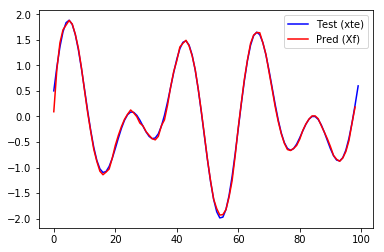

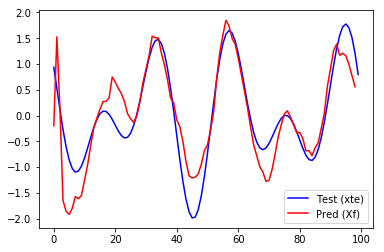

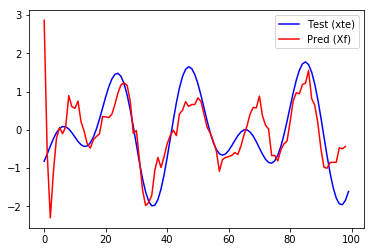

0.48523407241455407

In [18]:
#import scipy.linalg
from scipy import linalg
import random

random.seed(42)
np.random.seed(42)

def calc_mse(arr, Xf):
    return sum((arr-Xf)**2) / len(arr)

def ESN(ksteps, J, a=1, do_plot=False):
    # Training/Testing data split:
    split_ind = int(J.size/2)
    xtr = J[split_ind:-ksteps]
    xtr_ahead = J[split_ind+ksteps:]
    xte = J[:split_ind-ksteps]
    xte_ahead = J[ksteps:split_ind]

    resevoir_size = int(xtr.size/10)

    # Randomly initialise resevoir:
    a = 1
    wi = (np.random.rand(resevoir_size, 1)-0.5)*2
    wr = (np.random.rand(resevoir_size, resevoir_size)-0.5)*2
    p_wr = max(abs(linalg.eig(wr)[0]))  # Spectral radius of wr
    wr = (a * wr) / p_wr

    e = np.random.normal(0, 0.1)
    # Design matrix. Rows contain neural net state. Columns show time progression.
    X = np.zeros((resevoir_size, len(xtr)))
    Yt = np.zeros(resevoir_size)

    # First time step:
    xt = np.tanh(wi @ [xtr[0]] + e)
    for ji, j in enumerate(xtr):
        e = np.random.normal(0, 0.1)
        u = xtr[ji]
        xt = np.tanh(wr @ xt + wi @ [u] + e)
        X[:,ji] = xt

    alpha = 1
    Wo = linalg.inv(X @ X.T + (alpha**2) * np.identity(resevoir_size)) @ X @ xtr_ahead

    Xf = []
    xf = xt
    u = xte[0]
    # Do testing using Wo: (Forecasting)
    for ti, t in enumerate(xte):
        e = np.random.normal(0, 0.1)
        xf = np.tanh(wr @ xf + wi @ [u] + e)
        xf2 = Wo @ xf
        u = xte[ti]
        Xf.append(xf2)
        
    if do_plot:
        p_incr = 100
        plt.plot(xte_ahead[:p_incr], label='Test (xte)', color='blue')
        plt.plot(Xf[1:p_incr], label = 'Pred (Xf)', color='red')
        plt.legend()
        plt.show()
    return calc_mse(xte_ahead, Xf)

print('Forecasting the test data values for increasing k-step values: K=1  vs.  K=10  vs.  K=20')
ESN(1, J, a=1, do_plot=True)
ESN(10, J, a=1, do_plot=True)
ESN(20, J, a=1, do_plot=True)




The results show that (as expected), forecasting larger time-steps leads to a worse prediction. The next figure shows how the error of the prediction is affected by the number of (k) steps forecasted.

Text(0,0.5,'MSE')

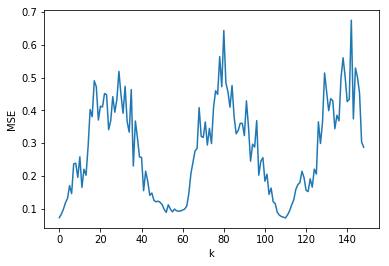

In [19]:
res = []
for k in range(1, 150):
    r = ESN(k, J, do_plot=False)
    #print(k, '  ', r)
    res.append(r)
plt.plot(res)
plt.xlabel('k')
plt.ylabel('MSE')

Interestingly, the error rises and falls with a wave-like pattern. This is most likely due to the data being periodic, meaning that as the prediction gets increasingly offset it might eventually be lining up again with the data's next wave-form.

In [20]:
print("The effect of the hyper-parameter a:")

res = []
for a in np.linspace(0.1, 2.1, num=9):
    k = 1
    r = ESN(k, J, a=a, do_plot=False)
    res.append(r)
    print('a:', a, '  r:', r)

The effect of the hyper-parameter a:
a: 0.1   r: 0.0711358700773
a: 0.35   r: 0.0705682049671
a: 0.6   r: 0.0706343644854
a: 0.85   r: 0.0717251352214
a: 1.1   r: 0.0717338995178
a: 1.35   r: 0.0715253502919
a: 1.6   r: 0.0717702448392
a: 1.85   r: 0.0713311251972
a: 2.1   r: 0.0715334158884


As seen from above, the hyper-parameter $a$ (used to calculate $W^r$) does not seem to have a large impact on the prediction accuracy

# PART 2:

This section implements a version of the ESN model that is trained online by means of the least-mean-square algorithm. The main change from the previous model is that $W_o$ is now calculated using an update-rule while processing the training data. This is specified by:

$$ \hat{w}(k+1) = \hat{w}(k) + \mu~x(k)~e(k) $$

Where $\hat{w}$ is an instantaneous estimate of the weight vector ($W_o$ previously), $\mu$ is the learning rate (a constant), $x(k)$ is the $k^{th}$ data point and $e(k)$ is the mean-square error.


Sinusoidal Forecasting Task:


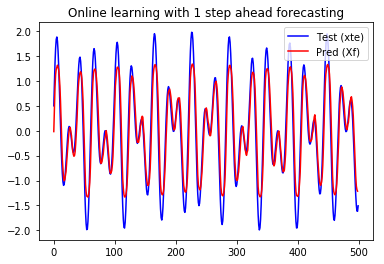

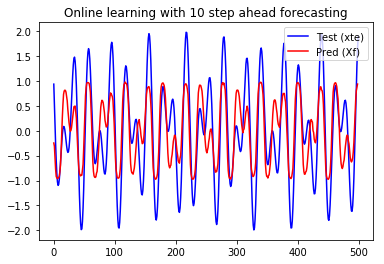

Lorenz Forecasting Task:


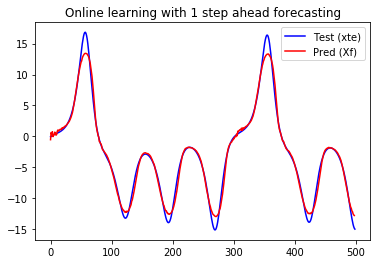

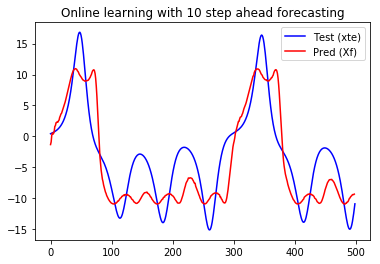

22.490575866214371

In [21]:
def calc_mse(arr, Xf):
    return sum((arr-Xf)**2) / len(arr)

def ESN_online(ksteps, J, do_plot=False):
    # Training data:
    split_ind = int(J.size/2)
    xtr = J[split_ind:-ksteps]
    xtr_ahead = J[split_ind+ksteps:]
    xte = J[:split_ind-ksteps]
    xte_ahead = J[ksteps:split_ind]

    resevoir_size = int(xtr.size/10)
    wi = (np.random.rand(resevoir_size, 1)-0.5)*2
    a = 1
    wr = (np.random.rand(resevoir_size, resevoir_size)-0.5)*2
    p_wr = max(abs(linalg.eig(wr)[0]))  # Spectral radius of wr
    wr = (a * wr) / p_wr

    e = np.random.normal(0, 0.1)
    X = np.zeros((resevoir_size, len(xtr)))  # Design matrix
    Yt = np.zeros(resevoir_size)

    Wo = np.zeros((resevoir_size))
    mu = 0.0001
    xt = np.tanh(wi @ [xtr[0]] + e)
    for ji, j in enumerate(xtr):
        e = np.random.normal(0, 0.1)
        u = xtr[ji]
        xt = np.tanh(wr @ xt + wi @ [u] + e)
        
        ek = xtr_ahead[ji] - (Wo @ xt)
        Wo = Wo + mu * xt * ek
    
    Xf = []
    xf = xt  # np.tanh(wi @ [xte[0]] + e)
    u = xte[0]
    # Do testing using training data: (Forecasting)
    for ti, t in enumerate(xte):
        e = np.random.normal(0, 0.1)
        xf = np.tanh(wr @ xf + wi @ [u] + e)
        xf2 = Wo @ xf
        #u = xf2
        u = xte[ti]
        Xf.append(xf2)
        
    if do_plot:
        p_incr = 500
        plt.plot(xte_ahead[:p_incr], label='Test (xte)', color='blue')
        plt.plot(Xf[1:p_incr], label = 'Pred (Xf)', color='red')
        plt.title("Online learning with " + str(ksteps) + " step ahead forecasting")
        plt.legend()
        plt.show()
    return calc_mse(xte_ahead, Xf)

print("")
print("Sinusoidal Forecasting Task:")
ESN_online(1, J, True)
ESN_online(10, J, True)

print("Lorenz Forecasting Task:")
ESN_online(1, I, True)
ESN_online(10, I, True)

The above graphs visually show the On-line learning ESN predicting less accurate results than batch learning, this will be quantified in the next section.

Simulations to compare the performance on a k-step ahead forecasting task with respect to the standard ESN implementation:

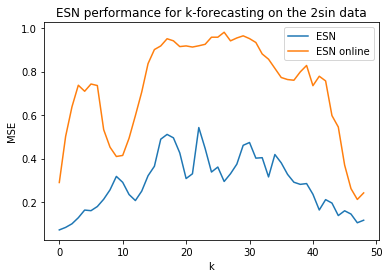

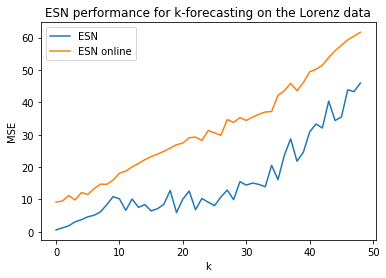

In [22]:
def compare_ESN_models(data, name, ksteps):
    res = [ESN(k, data, do_plot=False) for k in range(1, ksteps)]
    plt.plot(res, label='ESN')
    
    res = [ESN_online(k, data, do_plot=False) for k in range(1, ksteps)]
    plt.plot(res, label='ESN online')

    plt.title('ESN performance for k-forecasting on the ' + name + ' data')
    plt.xlabel('k')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
compare_ESN_models(J, '2sin', 50)
compare_ESN_models(I[:len(J)], 'Lorenz', 50)  # Subset of data used to speed up calculation


The results show that the On-line learning ESN is significantly less accurate than batch learning. This is due to the weight $W_o$ being calculated as each data point is processed. One situation in which the online approach could be helfpul is if the input data was live (and therefore you wouldn't have all of the input data yet), online learning could give immediate forecasting, and refine its output as more data was given.

Eitherway, ESN's are shown to be an effective approach for (small k-step) forecasting for temporal patterns.